In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.embedding import bar_embedding_freq, load_bar_embedding_freq, load_bar_embedding_total, bar_embedding_total, smooth_power
from groove.downbeats import get_measures, get_beat_frames, beat_peaks, get_beat_data, get_audio_data
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices
import groove


def simulate_num_components(data, num_trials, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False):
    counts = {}
    for _ in range(num_trials):
        n_components = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights).means_.shape[0]
        if n_components in counts:
            counts[n_components] += 1
        else:
            counts[n_components] = 1
    return counts




def do_clustering(data, confidence_limit=0.9, cluster_threshold=0.2, overlap_allowance=0.1, use_weights=False, verbose=False):
    gm = winnow_gm_components(data, confidence_limit=confidence_limit, cluster_threshold=cluster_threshold, overlap_allowance=overlap_allowance, use_weights=use_weights, verbose=verbose)
    print(f"Weights: {gm.weights_}")

    pca = PCA(n_components=2)
    pca.fit(data)
    print(f"PCA values: {pca.singular_values_}")

    return gm, pca

def do_projected_plot(gm, pca, data, confidence=0.9, data_list=None, file_list=None):

    red_data = pca.transform(data)
    patches, _ = get_patches(gm, confidence=confidence, pts=data, pca=pca)

    # Get axes min and max
    xlim = np.abs(red_data[:,0]).max() * 1.1
    ylim = np.abs(red_data[:,1]).max() * 1.1

    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.set_xlim([-xlim, xlim])
    ax.set_ylim([-ylim, ylim])

    if data_list != None:
        cmap = mpl.colormaps['gist_rainbow'](np.linspace(0, 1, len(data_list)))
        #plt.cm.get_cmap('hsv', len(data_list)+1)

        running_total = 0
        legend_patches = []
        for i, d in enumerate(data_list):
            plt.scatter(red_data[running_total:running_total + d.shape[0],0], red_data[running_total:running_total + d.shape[0],1], alpha=0.5, color=cmap[i], s=3)
            running_total += d.shape[0]
            if file_list != None:
                legend_patches.append(mpatches.Patch(color=cmap[i], label=file_list[i][0]))
        if file_list != None:
            ax.legend(handles=legend_patches)
    else:
        plt.scatter(red_data[:,0], red_data[:,1], alpha=0.7)
    
    for p in patches:
        ax.add_patch(p)

    return patches


from IPython.display import Audio
from groove.downbeats import get_measures, get_beat_frames, beat_peaks
from groove.embedding import smooth_power
import librosa
from typing import Callable

def do_bar_sample(indices, file, process: Callable, ext="mp3"):
    raw_measures, proc_measures, sr = get_measures(file, process, ext)
    for i in indices:
        raw, proc = raw_measures[i], proc_measures[i]
        #beat_frames = get_beat_frames([proc], sr, beat_peaks)[0][0]
        #clicks = librosa.clicks(times=beat_frames/sr, length=raw.shape[0], sr=sr)


        plt.figure(figsize=(20, 4))
        #plt.plot(raw)
        plt.plot(proc)
        #plt.scatter(beat_frames, np.zeros(beat_frames.shape), marker='o', color='red', zorder=10)
        display(Audio(data=raw, rate=sr))
        #display(Audio(data=raw + clicks, rate=sr))

In [1]:
import groove.embedding

proc_fn = groove.embedding.smooth_power

divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)


# file_list = ['milaklaw', '06 Encore A', 'lms', ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]
file_list = [ '06 Encore A',  ('09 D\'Angelo - Spanish Joint', 'm4a'), ('03 All the Pretty Girls', 'm4a')]

# Add extension
for i in range(len(file_list)):
    if type(file_list[i]) is not tuple:
        file_list[i] = (file_list[i], "mp3")

data_list = []
file_indices_list = []
indices_list = []
for i, (file, ext) in enumerate(file_list):
    data_list.append(load_bar_embedding_freq(file, divisions=divs, weights=wts, kernel_width=30, ext=ext))
    file_indices_list.append(np.full((data_list[i].shape[0],), i))
    indices_list.append(np.arange(data_list[i].shape[0]))

# Data, the index in file_list that the data came from, and the index inside its sublist
data = np.concatenate(data_list, axis=0)
data_file_inds = np.concatenate(file_indices_list, axis=0)
data_inds = np.concatenate(indices_list, axis=0)

NameError: name 'np' is not defined

In [2]:
#c = .8
#gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3, overlap_allowance=0.2, use_weights=False, verbose=True)

c = .8
gm, pca = do_clustering(data, confidence_limit=c, cluster_threshold=0.3/len(file_list), overlap_allowance=1, use_weights=False, verbose=True)

do_projected_plot(gm, pca, data, c, data_list=data_list, file_list=file_list)

NameError: name 'do_clustering' is not defined

In [17]:
data_list[1].shape

(159, 468)

In [19]:
enc = data_list[1]

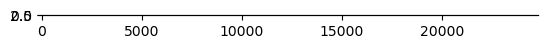

In [23]:
plt.imshow(enc.reshape(3,-1)[:10])

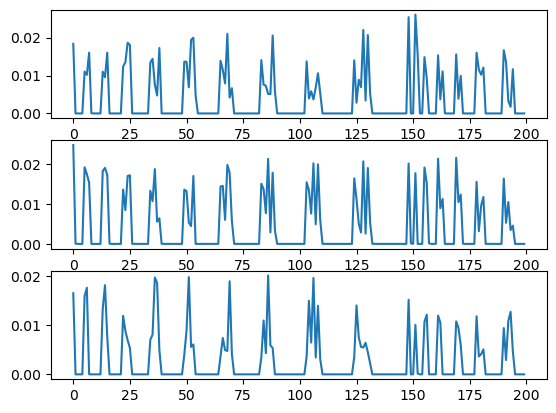

In [34]:
fig, axes = plt.subplots(3,1)
axes[0].plot(enc.reshape(-1,3)[5000:5200,0])
axes[1].plot(enc.reshape(-1,3)[5000:5200,1])
axes[2].plot(enc.reshape(-1,3)[5000:5200,2])